In [8]:
import torch
import kaolin as kal
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import logging
from typing import Optional, Dict, Any, Tuple, List
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from tqdm import tqdm

In [9]:
class GarmentDataset(Dataset):
    """Dataset class for loading and processing 3D garment meshes."""

    def __init__(self,
                 data_dir: str,
                 n_points: int = 2048,
                 transform: Optional[callable] = None) -> None:
        """
        Initialize the GarmentDataset.

        Args:
            data_dir (str): Directory containing the garment OBJ files
            n_points (int): Number of points to sample from each mesh
            transform (callable, optional): Transform to be applied on samples
        """
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.n_points = n_points
        self.file_paths = list(self.data_dir.glob('**/*.obj'))

        logging.info(f"Found {len(self.file_paths)} OBJ files in {data_dir}")

    def __len__(self) -> int:
        return len(self.file_paths)

    def sample_points(self,
                     vertices: torch.Tensor,
                     faces: torch.Tensor,
                     n_samples: Optional[int] = None) -> torch.Tensor:
        """
        Sample points uniformly from the mesh surface using area-weighted sampling.

        Args:
            vertices (torch.Tensor): Mesh vertices
            faces (torch.Tensor): Mesh faces
            n_samples (int, optional): Number of points to sample

        Returns:
            torch.Tensor: Sampled points (n_samples, 3)
        """
        if n_samples is None:
            n_samples = self.n_points

        # Convert to numpy for sampling
        vertices_np = vertices.numpy()
        faces_np = faces.numpy()

        # Get vertices for each face
        v0 = vertices_np[faces_np[:, 0]]
        v1 = vertices_np[faces_np[:, 1]]
        v2 = vertices_np[faces_np[:, 2]]

        # Calculate face areas for weighted sampling
        face_areas = 0.5 * np.linalg.norm(
            np.cross(v1 - v0, v2 - v0),
            axis=1
        )
        face_probs = face_areas / face_areas.sum()

        # Sample face indices based on area
        face_indices = np.random.choice(
            len(faces_np),
            size=n_samples,
            p=face_probs
        )

        # Sample points within triangles using barycentric coordinates
        r1 = np.random.random(n_samples)[:, np.newaxis]
        r2 = np.random.random(n_samples)[:, np.newaxis]
        sqrt_r1 = np.sqrt(r1)

        points = (
            (1 - sqrt_r1) * v0[face_indices] +
            sqrt_r1 * (1 - r2) * v1[face_indices] +
            sqrt_r1 * r2 * v2[face_indices]
        )

        return torch.from_numpy(points).float()

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        """
        Get a sample from the dataset.

        Args:
            idx (int): Index of the sample

        Returns:
            dict: Contains 'points' tensor and 'path' string
        """
        obj_path = self.file_paths[idx]

        # Load and process mesh
        mesh = kal.io.obj.import_mesh(str(obj_path))
        vertices = mesh.vertices.float()
        faces = mesh.faces.long()

        # Normalize and sample points
        vertices = self._normalize_vertices(vertices)
        points = self.sample_points(vertices, faces)

        sample = {
            'points': points,
            'path': str(obj_path)
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

    @staticmethod
    def _normalize_vertices(vertices: torch.Tensor) -> torch.Tensor:
        """
        Normalize vertices by centering and scaling.

        Args:
            vertices (torch.Tensor): Input vertices

        Returns:
            torch.Tensor: Normalized vertices
        """
        center = vertices.mean(dim=0)
        vertices = vertices - center
        scale = vertices.abs().max()
        return vertices / scale



In [10]:
class GarmentVAE(torch.nn.Module):
    """Variational Autoencoder for 3D garment point clouds."""

    def __init__(self,
                 point_dim: int = 3,
                 n_points: int = 2048,
                 hidden_dim: int = 512,
                 latent_dim: int = 256) -> None:
        """
        Initialize the VAE.

        Args:
            point_dim (int): Dimension of each point (default: 3 for 3D)
            n_points (int): Number of points in each cloud
            hidden_dim (int): Dimension of hidden layers
            latent_dim (int): Dimension of latent space
        """
        super().__init__()

        input_dim = point_dim * n_points

        # Encoder network
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.Linear(hidden_dim, latent_dim * 2)  # mu and logvar
        )

        # Decoder network
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.Linear(hidden_dim, input_dim)
        )

        self.n_points = n_points
        self.point_dim = point_dim
        self.latent_dim = latent_dim

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Encode input to mean and log variance in latent space."""
        h = self.encoder(x.view(x.size(0), -1))
        return torch.chunk(h, 2, dim=1)

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """Decode latent vector to point cloud."""
        return self.decoder(z).view(-1, self.n_points, self.point_dim)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """Perform reparameterization trick."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass through the VAE.

        Args:
            x (torch.Tensor): Input point cloud [B, N, 3]

        Returns:
            tuple: (reconstruction, mean, log variance)
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



In [ ]:
def chamfer_distance(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Compute chamfer distance between two point clouds.

    Args:
        x (torch.Tensor): First point cloud [B, N, D]
        y (torch.Tensor): Second point cloud [B, M, D]

    Returns:
        torch.Tensor: Chamfer distance
    """
    x = x.unsqueeze(2)  # [B, N, 1, D]
    y = y.unsqueeze(1)  # [B, 1, M, D]

    dist = torch.sum((x - y) ** 2, -1)  # [B, N, M]

    min_dist_xy = torch.min(dist, dim=2)[0]  # [B, N]
    min_dist_yx = torch.min(dist, dim=1)[0]  # [B, M]

    return torch.mean(min_dist_xy) + torch.mean(min_dist_yx)

In [11]:
class GarmentTrainer:
    """Trainer class for the GarmentVAE model."""

    def __init__(self,
                 model: GarmentVAE,
                 train_loader: torch.utils.data.DataLoader,
                 device: torch.device,
                 save_dir: str = "checkpoints"):
        """
        Initialize the trainer.

        Args:
            model: The VAE model
            train_loader: DataLoader for training data
            device: Device to train on (cuda/cpu)
            save_dir: Directory to save checkpoints
        """
        self.model = model.to(device)
        self.train_loader = train_loader
        self.device = device
        self.save_dir = Path(save_dir)
        self.save_dir.mkdir(exist_ok=True)

        self.optimizer = torch.optim.Adam(model.parameters())
        self.history = {'total_loss': [], 'recon_loss': [], 'kl_loss': []}

    def train(self,
              num_epochs: int,
              kl_weight: float = 0.1,
              save_interval: int = 5) -> dict:
        """
        Train the model.

        Args:
            num_epochs: Number of epochs to train
            kl_weight: Weight for KL divergence loss
            save_interval: Save checkpoint every n epochs

        Returns:
            dict: Training history
        """
        for epoch in range(num_epochs):
            epoch_losses = self._train_epoch(kl_weight)

            # Log progress
            print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
            for key, value in epoch_losses.items():
                print(f"{key}: {value:.4f}")
                self.history[key].append(value)

            # Save checkpoint
            if (epoch + 1) % save_interval == 0:
                self._save_checkpoint(epoch + 1)

        return self.history

    def _train_epoch(self, kl_weight: float) -> dict:
        """Train for one epoch."""
        self.model.train()
        total_loss = 0
        recon_loss = 0
        kl_loss = 0

        for batch in tqdm(self.train_loader, desc="Training"):
            points = batch['points'].to(self.device)

            # Forward pass
            recon, mu, logvar = self.model(points)

            # Compute losses
            recon_loss_batch = chamfer_distance(recon, points)
            kl_loss_batch = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss_batch + kl_weight * kl_loss_batch

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Accumulate losses
            total_loss += loss.item()
            recon_loss += recon_loss_batch.item()
            kl_loss += kl_loss_batch.item()

        # Calculate average losses
        num_batches = len(self.train_loader)
        return {
            'total_loss': total_loss / num_batches,
            'recon_loss': recon_loss / num_batches,
            'kl_loss': kl_loss / num_batches
        }

    def _save_checkpoint(self, epoch: int) -> None:
        """Save model checkpoint."""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'history': self.history
        }
        torch.save(checkpoint, self.save_dir / f'checkpoint_epoch_{epoch}.pth')

In [12]:
class GarmentVisualizer:
    """Class for visualizing garment point clouds and model results."""

    def __init__(self, model: GarmentVAE, device: torch.device):
        """
        Initialize the visualizer.

        Args:
            model: Trained VAE model
            device: Device for model inference
        """
        self.model = model.to(device)
        self.device = device
        self.model.eval()

    def generate_garment(self,
                        latent_vector: Optional[torch.Tensor] = None) -> np.ndarray:
        """Generate a garment point cloud."""
        with torch.no_grad():
            if latent_vector is None:
                latent_vector = torch.randn(1, self.model.latent_dim).to(self.device)

            points = self.model.decode(latent_vector)
            return points.cpu().numpy()

    def interpolate_garments(self,
                           garment1_path: str,
                           garment2_path: str,
                           dataset: GarmentDataset,
                           steps: int = 10) -> List[np.ndarray]:
        """Interpolate between two garments."""
        def encode_garment(path):
            mesh = kal.io.obj.import_mesh(path)
            points = dataset.sample_points(mesh.vertices, mesh.faces)
            with torch.no_grad():
                encoding = self.model.encoder(points.view(1, -1).to(self.device))
                return encoding[:, :self.model.latent_dim]

        with torch.no_grad():
            z1 = encode_garment(garment1_path)
            z2 = encode_garment(garment2_path)

            interpolations = []
            for alpha in np.linspace(0, 1, steps):
                z = alpha * z1 + (1 - alpha) * z2
                points = self.model.decode(z)
                interpolations.append(points.cpu().numpy())

            return interpolations

    def plot_point_cloud(self,
                        points: np.ndarray,
                        title: str = "Point Cloud",
                        interactive: bool = False) -> None:
        """Plot a point cloud."""
        if interactive:
            self._plot_interactive(points[0], title)
        else:
            self._plot_static(points[0], title)

    def plot_interpolation_grid(self,
                              interpolations: List[np.ndarray],
                              n_views: int = 3) -> None:
        """Plot interpolation results in a grid with multiple views."""
        views = [(0, 0), (45, 45), (90, 0)][:n_views]
        steps = len(interpolations)

        fig = plt.figure(figsize=(15, 5*n_views))
        for i, points in enumerate(interpolations):
            for j, (azim, elev) in enumerate(views):
                ax = fig.add_subplot(n_views, steps, i + 1 + j*steps, projection='3d')
                self._plot_points_on_axis(ax, points[0], azim, elev)
                if j == 0:
                    ax.set_title(f"Step {i}")

        plt.tight_layout()
        plt.show()

    @staticmethod
    def _plot_points_on_axis(ax, points, azim, elev):
        """Helper method to plot points on a matplotlib axis."""
        scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                           c=points[:, 2], cmap='viridis',
                           marker='.', s=20, alpha=0.6)
        ax.view_init(azim=azim, elev=elev)
        ax.axis('off')
        return scatter

    @staticmethod
    def _plot_interactive(points, title):
        """Create an interactive plotly visualization."""
        fig = go.Figure(data=[go.Scatter3d(
            x=points[:, 0], y=points[:, 1], z=points[:, 2],
            mode='markers',
            marker=dict(
                size=2,
                color=points[:, 2],
                colorscale='Viridis',
                opacity=0.8
            )
        )])

        fig.update_layout(
            title=title,
            scene=dict(
                xaxis_title='X',
                yaxis_title='Y',
                zaxis_title='Z',
                aspectmode='data'
            ),
            width=800,
            height=800
        )

        fig.show()

    @staticmethod
    def _plot_static(points, title):
        """Create a static matplotlib visualization."""
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                           c=points[:, 2], cmap='viridis',
                           marker='.', s=20, alpha=0.6)

        plt.colorbar(scatter)
        ax.set_title(title)
        plt.show()

def plot_training_history(history: dict) -> None:
    """Plot training history."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for ax, (key, values) in zip(axes, history.items()):
        ax.plot(values)
        ax.set_title(key)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GarmentVAE()
dataset = GarmentDataset("/content/drive/MyDrive/Multi-Garment_dataset")
train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Training
trainer = GarmentTrainer(model, train_loader, device)
history = trainer.train(num_epochs=20)
plot_training_history(history)

# Visualization
visualizer = GarmentVisualizer(model, device)

# Generate and visualize a new garment
points = visualizer.generate_garment()
visualizer.plot_point_cloud(points, interactive=True)

# Interpolate between two garments
interpolations = visualizer.interpolate_garments(
    "/content/drive/MyDrive/Multi-Garment_dataset/125611494287978/Pants.obj",
    "/content/drive/MyDrive/Multi-Garment_dataset/125611500934379/ShortPants.obj",
    dataset
)
visualizer.plot_interpolation_grid(interpolations)

In [19]:
class OriginalGarmentVAE(torch.nn.Module):
    def __init__(self, point_dim=3, hidden_dim=512, latent_dim=256):
        super().__init__()

        # Encoder - matches the original architecture
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(point_dim * 2048, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, latent_dim * 2)
        )

        # Decoder - matches the original architecture
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, point_dim * 2048)
        )

        self.latent_dim = latent_dim

    def decode(self, z):
        return self.decoder(z).view(-1, 2048, 3)

class GarmentAnalyzer:
    def __init__(self, model_path: str, device='cpu'):
        # Load model with the original architecture
        self.model = OriginalGarmentVAE()
        self.model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        self.model.eval()
        self.device = device
        self.model = self.model.to(device)

    def generate_variations(self, n_samples=5, n_views=3):
        """Generate different variations of garments with multiple views"""
        views = [(0, 0), (45, 45), (90, 0)][:n_views]
        fig = plt.figure(figsize=(15, 3*n_views))

        for i in range(n_samples):
            z = torch.randn(1, self.model.latent_dim).to(self.device)

            with torch.no_grad():
                points = self.model.decode(z)
                points = points.cpu().numpy()[0]

            for j, (azim, elev) in enumerate(views):
                ax = fig.add_subplot(n_views, n_samples, i + 1 + j*n_samples, projection='3d')
                scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                                   c=points[:, 2], cmap='viridis',
                                   marker='.', s=20, alpha=0.6)
                ax.view_init(azim=azim, elev=elev)

                if i == 0:
                    if j == 0:
                        ax.set_title(f"Front View\nVariation {i+1}")
                    elif j == 1:
                        ax.set_title(f"45° View\nVariation {i+1}")
                    else:
                        ax.set_title(f"Side View\nVariation {i+1}")
                else:
                    ax.set_title(f"Variation {i+1}")

                ax.axis('off')

        plt.tight_layout()
        plt.show()

    def generate_morphing_sequence(self, n_steps=10):
        """Generate a sequence of morphing between two random garments"""
        fig = plt.figure(figsize=(15, 5))

        # Generate two random latent vectors
        z1 = torch.randn(1, self.model.latent_dim).to(self.device)
        z2 = torch.randn(1, self.model.latent_dim).to(self.device)

        for i, alpha in enumerate(np.linspace(0, 1, n_steps)):
            # Interpolate between the two latent vectors
            z = alpha * z1 + (1 - alpha) * z2

            with torch.no_grad():
                points = self.model.decode(z)
                points = points.cpu().numpy()[0]

            ax = fig.add_subplot(1, n_steps, i+1, projection='3d')
            scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                               c=points[:, 2], cmap='viridis',
                               marker='.', s=20, alpha=0.6)
            ax.set_title(f'α={alpha:.1f}')
            ax.axis('off')

        plt.suptitle('Garment Morphing Sequence', size=16)
        plt.tight_layout()
        plt.show()

    def plot_garment_grid(self, rows=3, cols=3):
        """Plot a grid of random garments"""
        fig = plt.figure(figsize=(15, 15))

        for i in range(rows * cols):
            z = torch.randn(1, self.model.latent_dim).to(self.device)

            with torch.no_grad():
                points = self.model.decode(z)
                points = points.cpu().numpy()[0]

            ax = fig.add_subplot(rows, cols, i+1, projection='3d')
            scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                               c=points[:, 2], cmap='viridis',
                               marker='.', s=20, alpha=0.6)
            ax.set_title(f'Sample {i+1}')
            ax.axis('off')

        plt.suptitle('Random Garment Samples', size=16)
        plt.tight_layout()
        plt.show()



In [22]:
# Create analyzer
analyzer = GarmentAnalyzer("/content/garment_vae.pth")



<ipython-input-19-601d09b73f2e>:37: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



1. Generating variations with multiple views...


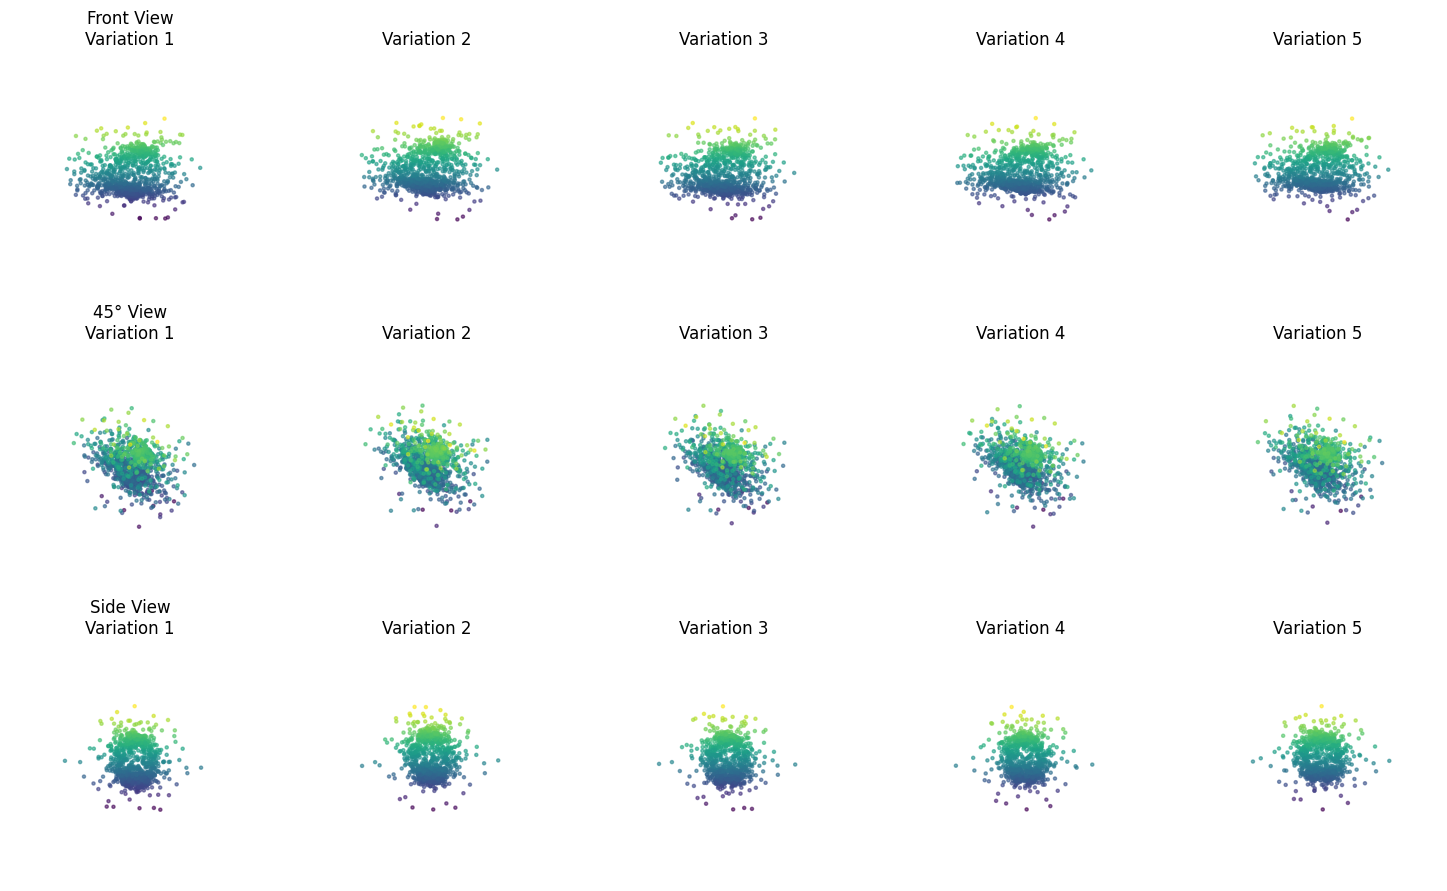

In [23]:
print("1. Generating variations with multiple views...")
analyzer.generate_variations()



2. Generating morphing sequence...


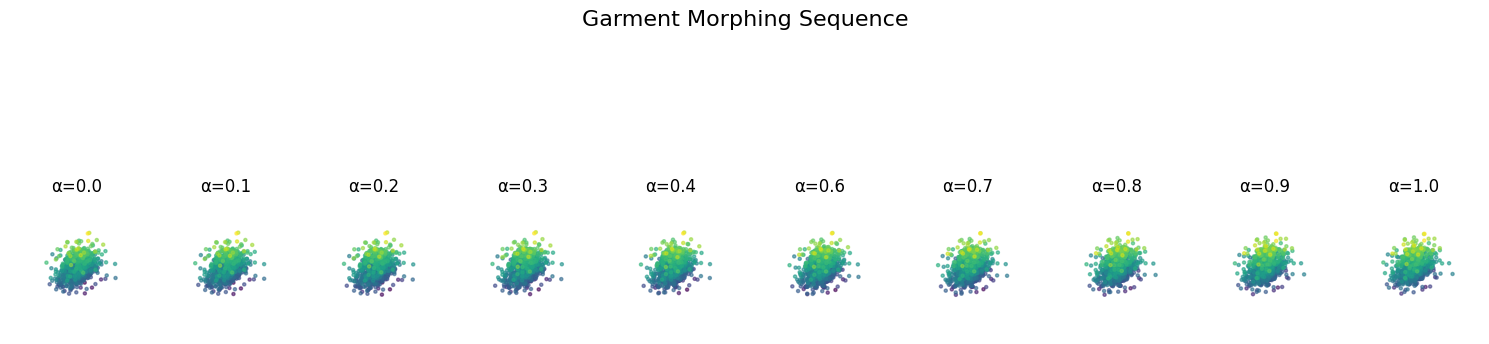

In [24]:

print("\n2. Generating morphing sequence...")
analyzer.generate_morphing_sequence()



3. Generating garment grid...


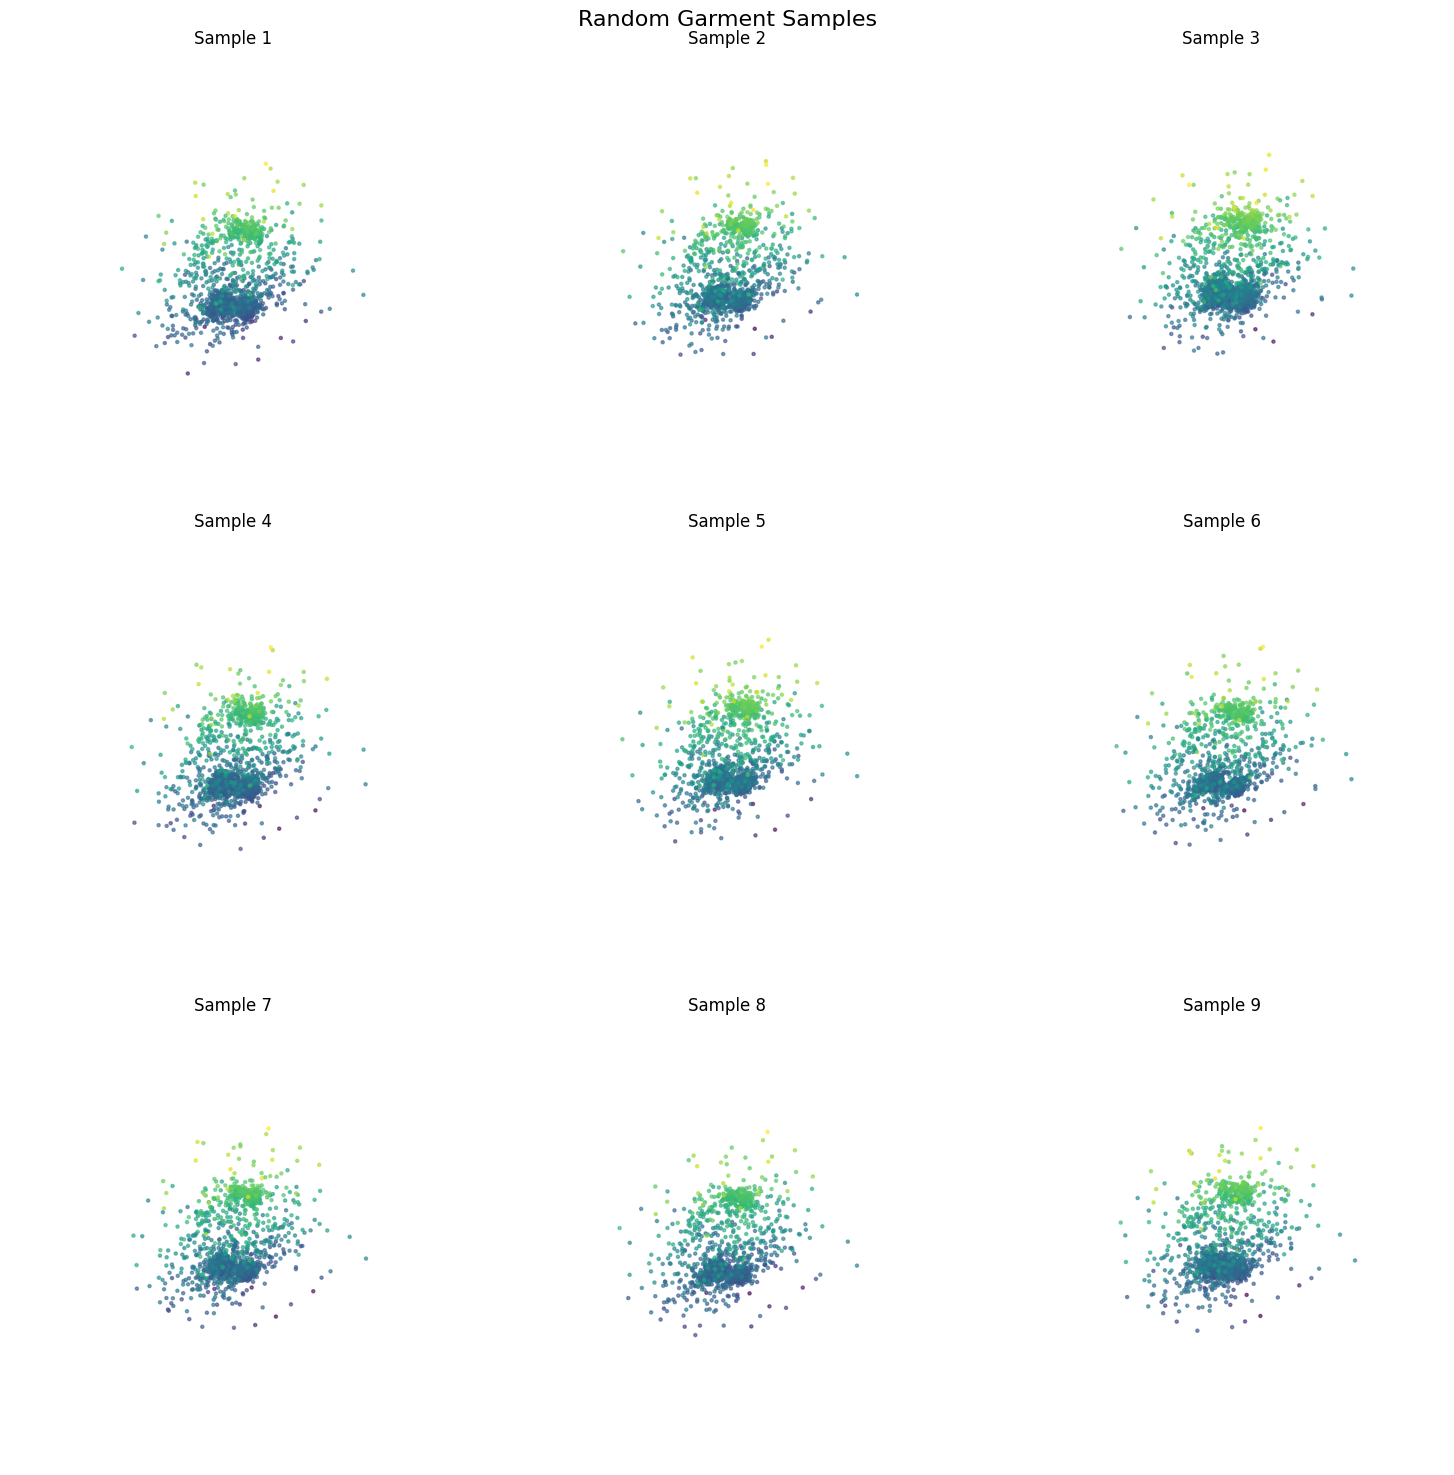

In [25]:

print("\n3. Generating garment grid...")
analyzer.plot_garment_grid()

In [32]:
class GarmentAnalysisTools:
    def __init__(self, model_path: str, device='cpu'):
        self.model = OriginalGarmentVAE()
        self.model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        self.model.eval()
        self.device = device
        self.model = self.model.to(device)

    def analyze_garment_features(self, points):
        """Analyze geometric features of the garment"""
        # Calculate bounding box
        min_coords = np.min(points, axis=0)
        max_coords = np.max(points, axis=0)
        dimensions = max_coords - min_coords

        # Calculate point density distribution
        nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(points)
        distances, _ = nbrs.kneighbors(points)
        local_density = 1 / (np.mean(distances, axis=1) + 1e-6)

        # Analyze symmetry
        center = (max_coords + min_coords) / 2
        left_mask = points[:, 0] < center[0]
        right_mask = points[:, 0] > center[0]
        symmetry_score = np.abs(np.sum(left_mask) - np.sum(right_mask)) / len(points)

        return {
            'dimensions': dimensions,
            'volume': np.prod(dimensions),
            'height': dimensions[2],
            'width': dimensions[0],
            'depth': dimensions[1],
            'density_stats': {
                'mean': np.mean(local_density),
                'std': np.std(local_density),
                'max': np.max(local_density),
                'min': np.min(local_density)
            },
            'symmetry_score': symmetry_score
        }

    def visualize_with_analysis(self, points):
        """Create enhanced visualization with feature analysis"""
        fig = plt.figure(figsize=(20, 5))

        # 1. Basic point cloud
        ax1 = fig.add_subplot(141, projection='3d')
        scatter = ax1.scatter(points[:, 0], points[:, 1], points[:, 2],
                            c=points[:, 2], cmap='viridis',
                            marker='.', s=20, alpha=0.6)
        ax1.set_title('Height Distribution')
        plt.colorbar(scatter, ax=ax1, label='Height')

        # 2. Density distribution
        nbrs = NearestNeighbors(n_neighbors=10).fit(points)
        distances, _ = nbrs.kneighbors(points)
        density = 1 / (np.mean(distances, axis=1) + 1e-6)

        ax2 = fig.add_subplot(142, projection='3d')
        scatter = ax2.scatter(points[:, 0], points[:, 1], points[:, 2],
                            c=density, cmap='plasma',
                            marker='.', s=20, alpha=0.6)
        plt.colorbar(scatter, ax=ax2, label='Local Density')
        ax2.set_title('Point Density')

        # 3. Symmetry analysis
        center = np.mean(points, axis=0)
        distances_from_center = np.abs(points[:, 0] - center[0])

        ax3 = fig.add_subplot(143, projection='3d')
        scatter = ax3.scatter(points[:, 0], points[:, 1], points[:, 2],
                            c=distances_from_center, cmap='RdYlBu',
                            marker='.', s=20, alpha=0.6)
        plt.colorbar(scatter, ax=ax3, label='Distance from Center')
        ax3.set_title('Symmetry Analysis')

        # 4. Segmentation by height
        height_segments = np.digitize(points[:, 2],
                                    bins=np.linspace(min(points[:, 2]),
                                                   max(points[:, 2]), 4))

        ax4 = fig.add_subplot(144, projection='3d')
        scatter = ax4.scatter(points[:, 0], points[:, 1], points[:, 2],
                            c=height_segments, cmap='tab10',
                            marker='.', s=20, alpha=0.6)
        ax4.set_title('Height Segments')

        plt.tight_layout()
        plt.show()

    def create_interactive_plot(self, points, features=None):
        """Create interactive Plotly visualization"""
        if features is None:
            features = self.analyze_garment_features(points)

        # Create the main point cloud visualization
        fig = go.Figure(data=[
            go.Scatter3d(
                x=points[:, 0],
                y=points[:, 1],
                z=points[:, 2],
                mode='markers',
                marker=dict(
                    size=2,
                    color=points[:, 2],
                    colorscale='Viridis',
                    opacity=0.8
                ),
                hoverinfo='none'
            )
        ])

        # Add feature annotations
        feature_text = [
            f"Dimensions (W×D×H): {features['width']:.2f} × {features['depth']:.2f} × {features['height']:.2f}",
            f"Volume: {features['volume']:.2f}",
            f"Symmetry Score: {features['symmetry_score']:.2f}",
            f"Mean Density: {features['density_stats']['mean']:.2f}"
        ]

        fig.update_layout(
            title='Interactive Garment Analysis',
            scene=dict(
                annotations=[dict(
                    text='<br>'.join(feature_text),
                    x=0.02,
                    y=0.98,
                    showarrow=False,
                    font=dict(size=12)
                )],
                xaxis_title='X',
                yaxis_title='Y',
                zaxis_title='Z',
                aspectmode='data'
            ),
            width=800,
            height=800
        )

        fig.show()


<ipython-input-32-e8da2b9c0992>:11: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Analyzing garment features...

Feature Analysis:
dimensions: [1.5775471 1.8764337 0.7660905]
volume: 2.2677524089813232
height: 0.7660905122756958
width: 1.5775470733642578
depth: 1.8764337301254272
density_stats:
  mean: 65.3160
  std: 45.8697
  max: 194.7435
  min: 2.8963
symmetry_score: 0.095703125

Generating visualizations...


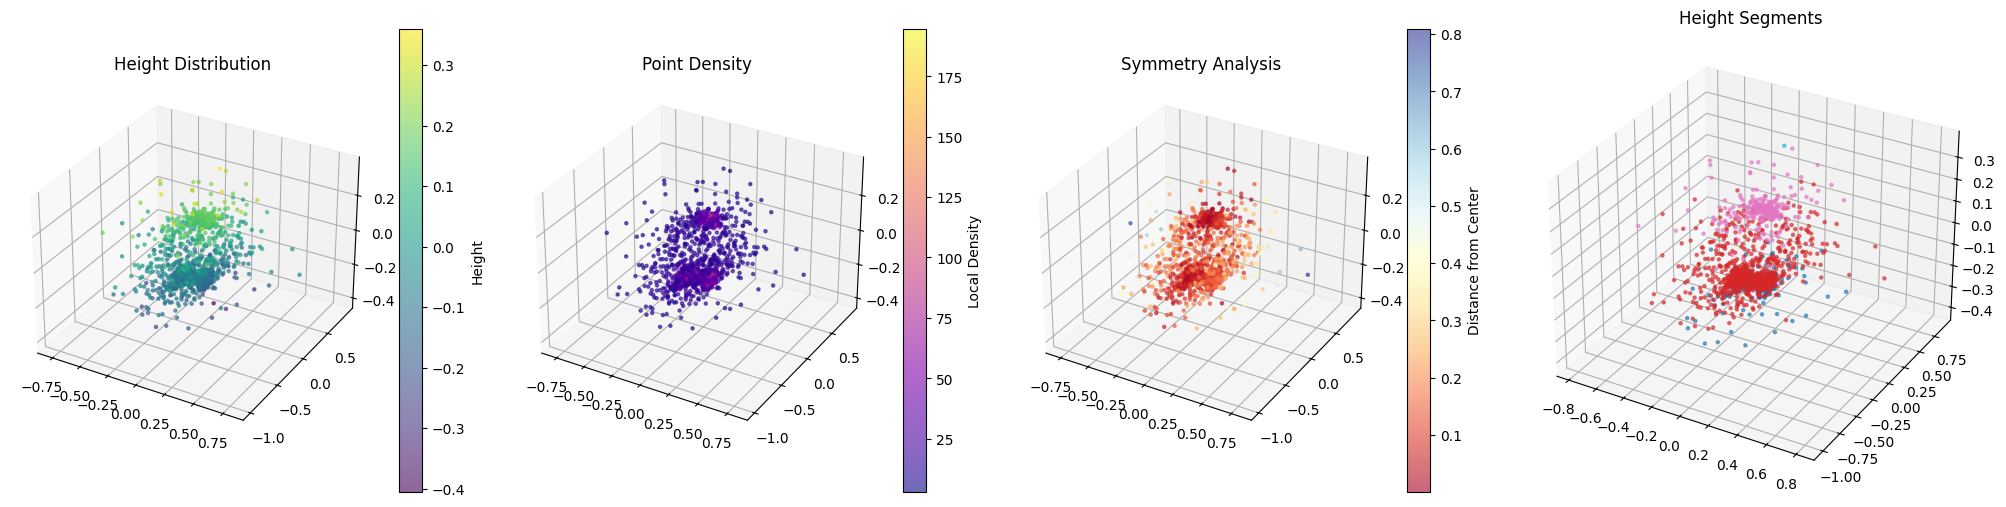


Creating interactive visualization...


In [33]:
analyzer = GarmentAnalysisTools("garment_vae.pth")

# Generate a sample garment
with torch.no_grad():
    z = torch.randn(1, analyzer.model.latent_dim).to(analyzer.device)
    points = analyzer.model.decode(z)
    points = points.cpu().numpy()[0]

# Display different analyses
print("Analyzing garment features...")
features = analyzer.analyze_garment_features(points)

print("\nFeature Analysis:")
for key, value in features.items():
    if isinstance(value, dict):
        print(f"{key}:")
        for subkey, subvalue in value.items():
            print(f"  {subkey}: {subvalue:.4f}")
    else:
        print(f"{key}: {value}")

print("\nGenerating visualizations...")
analyzer.visualize_with_analysis(points)

print("\nCreating interactive visualization...")
analyzer.create_interactive_plot(points, features)